# 6) Character Interaction Graph 
This notebook is part of **Applied NLP – Session 2: Phrases & Collocations**.

Overview:
- Visualize word collocations as a network graph where nodes are words and edges are bigram co-occurrences.
- Identify hub words (high degree) that co-occur frequently with many other words.
- Filter edges by frequency threshold to focus on strong collocations and reveal phrase structure.

In [5]:
# ===== Imports & Config =====
import re, os, math, json, collections
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# --- Standard Config (for file paths) ---
CONFIG = {
    "book1_path": "..\\data\\Fellowship.txt",
    "book2_path": "..\\data\\TwoTowers.txt",
    "book3_path": "..\\data\\TheKing.txt",
}

# Unicode-aware token regex
WORD_RE = re.compile(r"[^\W\d_]+(?:[-'][^\W\d_]+)*", flags=re.UNICODE)

# --- New Character Config ---
# Defines the "nodes" of our graph.
# Add or remove names as you see fit.
CHARACTERS = {
    "Frodo": ["frodo", "baggins"],
    "Sam": ["sam", "samwise", "gamgee"],
    "Gandalf": ["gandalf", "mithrandir"],
    "Aragorn": ["aragorn", "strider", "elessar"],
    "Legolas": ["legolas"],
    "Gimli": ["gimli"],
    "Boromir": ["boromir"],
    "Pippin": ["pippin", "took", "peregrin"],
    "Merry": ["merry", "meriadoc", "brandybuck"],
    "Gollum": ["gollum", "smeagol"],
    "Saruman": ["saruman"],
    "Sauron": ["sauron", "dark lord", "lord of the rings"],
    "Theoden": ["theoden", "king"],
    "Eowyn": ["eowyn"],
    "Faramir": ["faramir"],
    "Elrond": ["elrond"],
    "Galadriel": ["galadriel", "lady"],
    "Treebeard": ["treebeard", "fangorn"],
    "Denethor": ["denethor"],
}

print("Cell 1: Config loaded.")

Cell 1: Config loaded.


In [6]:
# ===== Text Loading & Helper Functions =====

# --- Robust Project Gutenberg boilerplate stripper (from Note) ---
_GB_START_MARKERS = [
    r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK",   # modern
    r"START OF (THIS|THE) PROJECT GUTENBERG EBOOK",             # fallback
]
_GB_END_MARKERS = [
    r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK",      # modern
    r"END OF (THIS|THE) PROJECT GUTENBERG EBOOK",                # fallback
]
_CHAPTER_HINTS = [
    r"^\s*chapter\s+[ivxlcdm0-9]+[\.\: ]",   # CHAPTER I / Chapter 1
    r"^\s*book\s+[ivxlcdm0-9]+[\.\: ]",      # BOOK I etc.
]

def strip_gutenberg(text: str) -> str:
    """Heuristically strips Gutenberg headers/footers."""
    t = text.replace("\ufeff", "")  # strip BOM
    start_idx, end_idx = None, None
    for pat in _GB_START_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            start_idx = t.find("\n", m.end())
            if start_idx == -1: start_idx = m.end()
            break
    for pat in _GB_END_MARKERS:
        m = re.search(pat, t, flags=re.IGNORECASE)
        if m:
            end_idx = m.start()
            break
    if start_idx is not None and end_idx is not None and end_idx > start_idx:
        core = t[start_idx:end_idx]
    else: # Fallback
        core = t
        for pat in _CHAPTER_HINTS:
            m = re.search(pat, core, flags=re.IGNORECASE | re.MULTILINE)
            if m: core = core[m.start():]
            break
    return core.strip()

def load_text(p: str) -> str:
    with open(p, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def normalize_text(t: str) -> str:
    t = strip_gutenberg(t)
    t = t.replace("’", "'") # Normalize apostrophes
    t = t.replace("‘", "'")
    t = re.sub(r"-\s*\n", "", t) # Join hyphenated line breaks
    t = re.sub(r"\s+", " ", t) # Normalize whitespace
    return t

# --- Load and Tokenize All Three Books ---
print("Loading and normalizing texts...")
text1 = normalize_text(load_text(CONFIG["book1_path"]))
text2 = normalize_text(load_text(CONFIG["book2_path"]))
text3 = normalize_text(load_text(CONFIG["book3_path"]))

tokens1 = WORD_RE.findall(text1.lower())
tokens2 = WORD_RE.findall(text2.lower())
tokens3 = WORD_RE.findall(text3.lower())

print(f"Book 1 (Fellowship) tokens: {len(tokens1):,}")
print(f"Book 2 (Towers) tokens: {len(tokens2):,}")
print(f"Book 3 (Return) tokens: {len(tokens3):,}")

# --- Build the Alias-to-Character Lookup Map ---
# This is a crucial step.
# We create a dictionary that maps "frodo" -> "Frodo", "strider" -> "Aragorn", etc.
# This way, all variations count towards the same character node.

char_alias_map = {}
for main_name, alias_list in CHARACTERS.items():
    for alias in alias_list:
        # Handle multi-word aliases like "dark lord"
        if " " in alias:
            # We'll handle this in the token normalization step
            pass
        else:
            char_alias_map[alias] = main_name

print(f"\nCreated lookup map for {len(char_alias_map)} aliases.")
print("Cell 2: Texts loaded and tokenized.")

Loading and normalizing texts...
Book 1 (Fellowship) tokens: 187,201
Book 2 (Towers) tokens: 153,824
Book 3 (Return) tokens: 135,180

Created lookup map for 33 aliases.
Cell 2: Texts loaded and tokenized.


In [7]:
import itertools
from collections import defaultdict

def build_character_edges(token_list, char_alias_map, main_char_names, window_size=50):
    """
    Slides a window over a token list to find character co-occurrences.
    
    Returns:
        A dictionary of edges, e.g. {('Frodo', 'Sam'): 250, ('Gimli', 'Legolas'): 100}
    """
    
    # This list will hold the main character name for each token, or None
    # e.g. [None, None, 'Frodo', None, 'Aragorn', None, ...]
    normalized_tokens = [char_alias_map.get(token) for token in token_list]
    
    edges = defaultdict(int)
    
    # Slide the window over the normalized token list
    for i in range(len(normalized_tokens) - window_size):
        window = normalized_tokens[i : i + window_size]
        
        # Find all *unique* characters present in this window
        # We use a set to avoid double-counting (e.g., if "Frodo" is said 3 times)
        chars_in_window = set(token for token in window if token is not None)
        
        # If there are 2 or more different characters, they are interacting.
        if len(chars_in_window) >= 2:
            # Create all unique pairs, e.g. (Frodo, Sam), (Frodo, Gandalf), (Sam, Gandalf)
            # We sort the pair to make sure ('Frodo', 'Sam') and ('Sam', 'Frodo') count as the same edge.
            for char_a, char_b in itertools.combinations(sorted(list(chars_in_window)), 2):
                edges[(char_a, char_b)] += 1
                
    return edges

# Get the set of main names, e.g. {'Frodo', 'Sam', 'Gandalf', ...}
main_characters = set(CHARACTERS.keys())

# --- Run the analysis for each book ---
print("Building character networks (this may take a moment)...")

print("Processing Book 1: Fellowship...")
edges_book1 = build_character_edges(tokens1, char_alias_map, main_characters)
print("Processing Book 2: Towers...")
edges_book2 = build_character_edges(tokens2, char_alias_map, main_characters)
print("Processing Book 3: Return...")
edges_book3 = build_character_edges(tokens3, char_alias_map, main_characters)

print("\nAnalysis complete.")

# --- Show a quick preview of the results ---
def print_top_edges(edge_data, book_name, top_n=5):
    if not edge_data:
        print(f"\nNo edges found for {book_name}.")
        return
    
    print(f"\n--- Top {top_n} Interactions in {book_name} ---")
    # Sort the edges by weight (descending)
    sorted_edges = sorted(edge_data.items(), key=lambda item: item[1], reverse=True)
    for (char_a, char_b), weight in sorted_edges[:top_n]:
        print(f"  {char_a} <-> {char_b}: {weight} co-occurrences")

print_top_edges(edges_book1, "Book 1 (Fellowship)")
print_top_edges(edges_book2, "Book 2 (Towers)")
print_top_edges(edges_book3, "Book 3 (Return)")

Building character networks (this may take a moment)...
Processing Book 1: Fellowship...
Processing Book 2: Towers...
Processing Book 3: Return...

Analysis complete.

--- Top 5 Interactions in Book 1 (Fellowship) ---
  Frodo <-> Sam: 7723 co-occurrences
  Frodo <-> Gandalf: 6635 co-occurrences
  Aragorn <-> Frodo: 5787 co-occurrences
  Frodo <-> Pippin: 5643 co-occurrences
  Frodo <-> Merry: 3899 co-occurrences

--- Top 5 Interactions in Book 2 (Towers) ---
  Frodo <-> Sam: 7643 co-occurrences
  Gollum <-> Sam: 4585 co-occurrences
  Frodo <-> Gollum: 4251 co-occurrences
  Gimli <-> Legolas: 3091 co-occurrences
  Merry <-> Pippin: 2902 co-occurrences

--- Top 5 Interactions in Book 3 (Return) ---
  Frodo <-> Sam: 8842 co-occurrences
  Gandalf <-> Pippin: 3815 co-occurrences
  Merry <-> Pippin: 2515 co-occurrences
  Frodo <-> Pippin: 2068 co-occurrences
  Denethor <-> Gandalf: 1759 co-occurrences


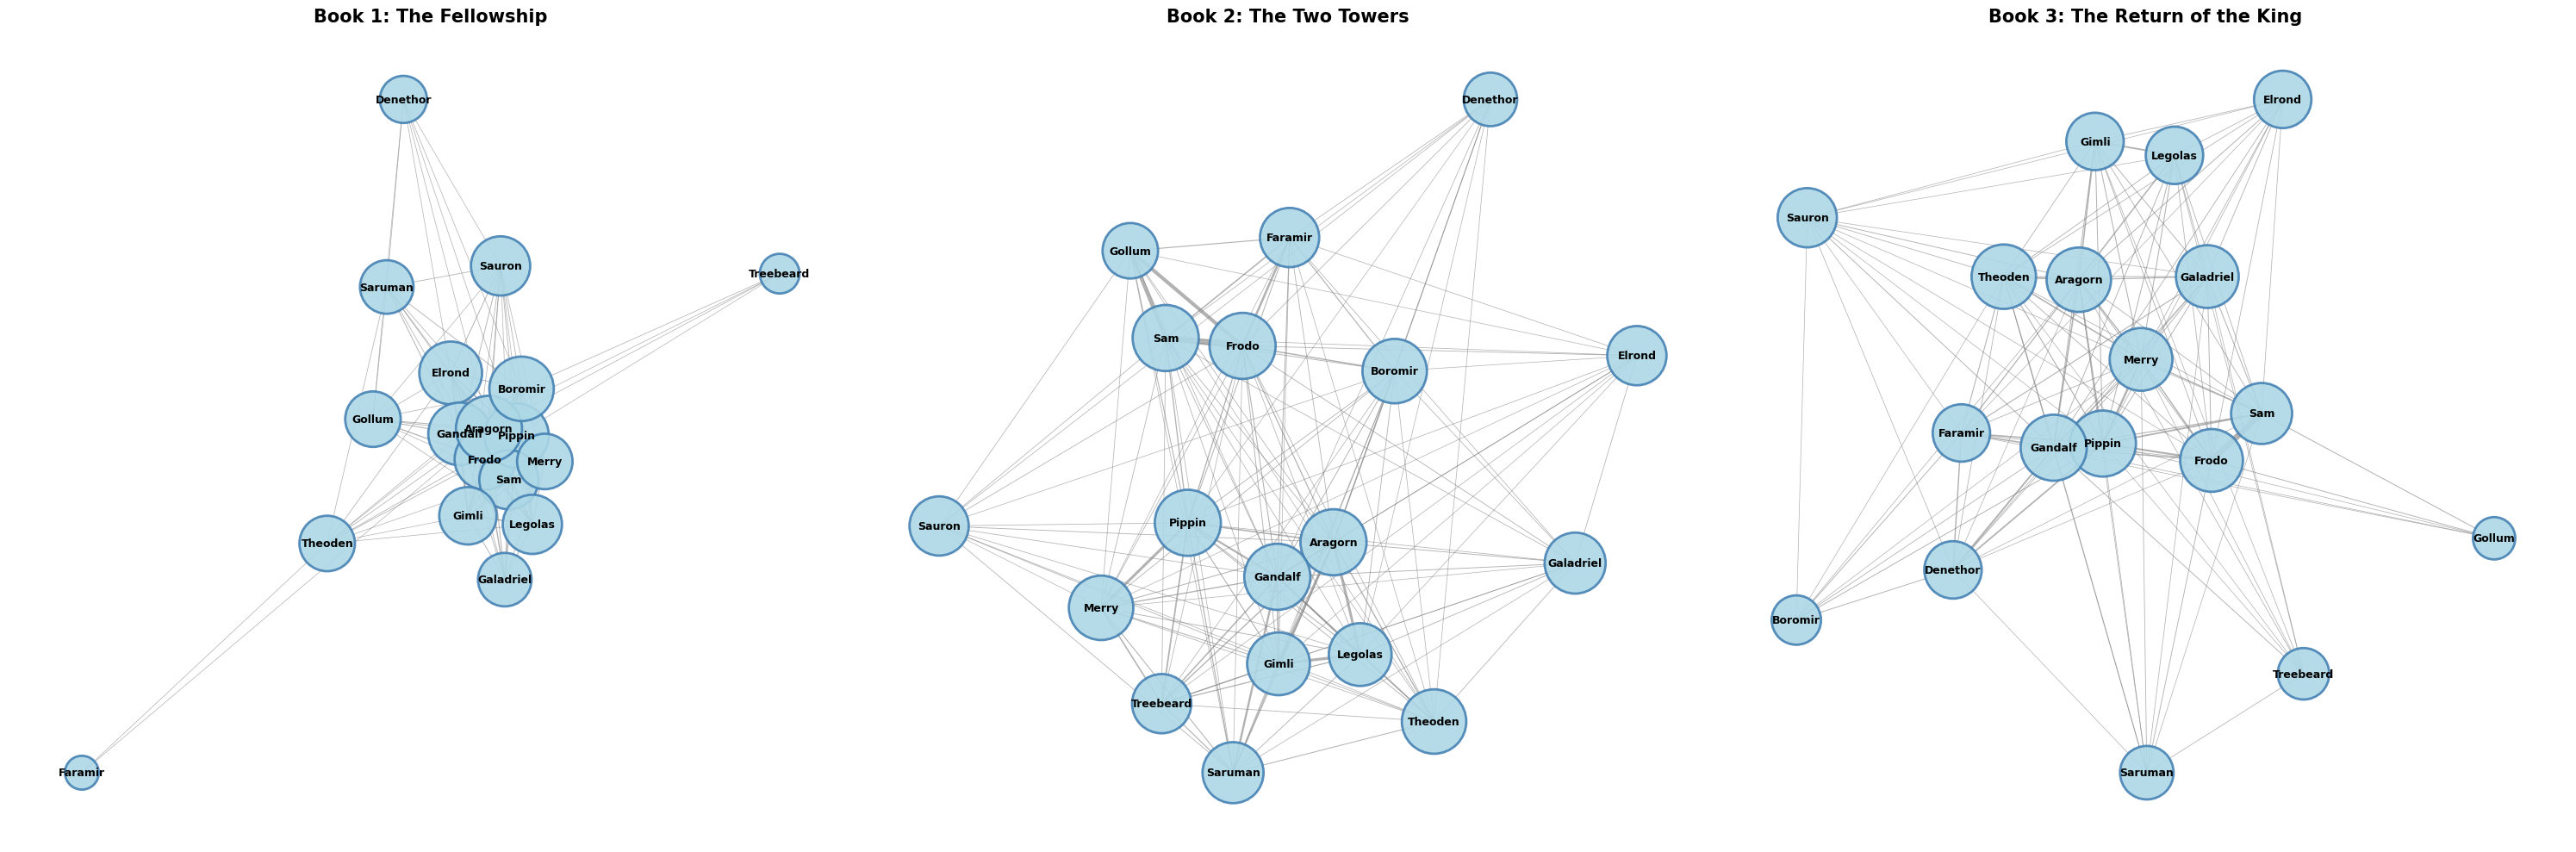

Saved graph to ../results/character_networks.png


In [8]:
import numpy as np

def draw_character_network(ax, edge_data, book_title):
    """
    Draws a character network graph on a given matplotlib axis.
    """
    
  # 1. Create the graph from our edge data
    G = nx.Graph()
    for (char_a, char_b), weight in edge_data.items():
        if weight > 0:
            G.add_edge(char_a, char_b, weight=weight)
            
    if not G.nodes():
        ax.set_title(f"{book_title}\n(No character interactions found)")
        ax.axis('off')
        return

    # 2. Calculate layout
    # === FINAL FIX: Aggressively increased 'k' and 'iterations' ===
    # k controls the optimal distance between nodes. Higher = more spread.
    # iterations gives the algorithm more time to find a good layout.
    pos = nx.spring_layout(G, k=0.9, iterations=100, seed=42, weight='weight')

    # 3. Get node and edge attributes for drawing
    
    # Node size: based on "degree"
    degrees = dict(G.degree())
    node_sizes = [degrees.get(node, 0) * 150 + 500 for node in G.nodes()]
    
    # Edge width: based on "weight"
    weights = [G[u][v]['weight'] for u, v in G.edges()]
    
    if weights:
        min_w, max_w = min(weights), max(weights)
        norm_weights = [(w - min_w) / (max_w - min_w + 1e-6) for w in weights]
        edge_widths = [0.5 + 4.5 * w for w in norm_weights]
    else:
        edge_widths = [1] * len(G.edges())

    # 4. Draw the graph
    nx.draw_networkx_nodes(
        G, pos,
        ax=ax,
        node_size=node_sizes,
        node_color='lightblue',
        edgecolors='steelblue',
        alpha=0.9,
        linewidths=2
    )
    
    nx.draw_networkx_edges(
        G, pos,
        ax=ax,
        width=edge_widths,
        edge_color='gray',
        alpha=0.6
    )
    
    nx.draw_networkx_labels(
        G, pos,
        ax=ax,
        font_size=9, # Keep font small
        font_weight='bold'
    )
    
    ax.set_title(book_title, fontsize=15, fontweight='bold')
    ax.axis('off')

# --- Create the 1x3 Plot Grid ---
# === FINAL FIX: Made figure even wider ===
fig, axes = plt.subplots(1, 3, figsize=(30, 10)) 

draw_character_network(axes[0], edges_book1, "Book 1: The Fellowship")
draw_character_network(axes[1], edges_book2, "Book 2: The Two Towers")
draw_character_network(axes[2], edges_book3, "Book 3: The Return of the King")

plt.tight_layout()
plt.show()

# Save the final figure
fig.savefig("../results/character_networks.png", dpi=200, bbox_inches="tight")
print("Saved graph to ../results/character_networks.png")

In [12]:
import spacy

# Load a small spaCy model (we only need the tokenizer)
# Run 'pip install en_core_web_sm' if you don't have it
nlp = spacy.load("en_core_web_sm")

# --- Simple Dialogue Finder ---
# This is a basic heuristic. It finds "..." said NAME or NAME said "..."
# It will miss a LOT, but it's a good start.
# We look for a quote followed by "said" and a Character Name
dialogue_pattern_1 = re.compile(
    r'"([^"]+)"\s+(?:said|cried|shouted|asked|replied)\s+([a-z]+)',
    re.IGNORECASE
)
# We look for a Character Name followed by "said" and a quote
dialogue_pattern_2 = re.compile(
    r'([a-z]+)\s+(?:said|cried|shouted|asked|replied),\s*"([^"]+)"',
    re.IGNORECASE
)

def find_directed_dialogue(token_list, char_alias_map, window_size=50):
    """
    Finds directed Speaker -> Addressee interactions.
    
    Returns a dict:
    { ("Speaker", "Addressee"): Counter(list_of_phrases) }
    """
    
    # This will store all phrases for each pair
    # e.g. {("Gandalf", "Frodo"): ["don't be", "you must", "don't be"] }
    directed_edges = defaultdict(list)
    
    # 1. Re-join tokens into text for regex
    raw_text = " ".join(token_list)
    
    # 2. Find all matches for "..." said NAME
    matches = list(dialogue_pattern_1.finditer(raw_text))
    matches.extend(list(dialogue_pattern_2.finditer(raw_text)))
    
    for match in matches:
        if match.re == dialogue_pattern_1:
            dialogue, speaker_token = match.groups()
        else:
            speaker_token, dialogue = match.groups()

        # 3. Find the Speaker's main name
        speaker = char_alias_map.get(speaker_token.lower())
        if not speaker:
            continue # Not a character we are tracking

        # 4. Find the Addressee (who else is nearby?)
        # Get the position of the dialogue in the full token list
        start_pos = token_list.index(speaker_token)
        
        # Get the 50-word window *around* the speaker
        window_start = max(0, start_pos - (window_size // 2))
        window_end = min(len(token_list), start_pos + (window_size // 2))
        
        # Normalize the tokens in that window
        normalized_window = [char_alias_map.get(t) for t in token_list[window_start:window_end]]
        
        # Find all *other* unique characters in that window
        addressees = set(
            char for char in normalized_window 
            if char is not None and char != speaker
        )

        # 5. Tokenize the dialogue and find bigrams
        dialogue_tokens = [t.text.lower() for t in nlp(dialogue) if t.is_alpha and not t.is_stop]
        phrases = [" ".join(ng) for ng in zip(dialogue_tokens, dialogue_tokens[1:])]
        
        # 6. Create the directed edges
        for addressee in addressees:
            directed_edges[(speaker, addressee)].extend(phrases)
            
    # 7. Roll up the results
    # Convert {("G", "F"): ["a", "b", "a"]} to {("G", "F"): ("a", 2)}
    top_phrases_map = {}
    for (speaker, addressee), phrases in directed_edges.items():
        if phrases:
            # Find the single most common phrase
            top_phrase = Counter(phrases).most_common(1)[0] # (phrase, count)
            top_phrases_map[(speaker, addressee)] = top_phrase

    return top_phrases_map

# --- Run the New Analysis ---
print("Building DIRECTED character networks...")
print("(This is a slow process, it may take a minute...)")

print("Processing Book 1: Fellowship...")
directed_edges_b1 = find_directed_dialogue(tokens1, char_alias_map)
print("Processing Book 2: Towers...")
directed_edges_b2 = find_directed_dialogue(tokens2, char_alias_map)
print("Processing Book 3: Return...")
directed_edges_b3 = find_directed_dialogue(tokens3, char_alias_map)

print("\nAnalysis complete.")

# --- Show a quick preview ---
print("\n--- Top Directed Interactions (Book 1) ---")
for (speaker, addressee), (phrase, count) in list(directed_edges_b1.items())[:5]:
    print(f'  {speaker} -> {addressee} (phrase: "{phrase}", count: {count})')

Building DIRECTED character networks...
(This is a slow process, it may take a minute...)
Processing Book 1: Fellowship...
Processing Book 2: Towers...
Processing Book 3: Return...

Analysis complete.

--- Top Directed Interactions (Book 1) ---


In [11]:
# This cell creates a focused graph for Book 1 with edge labels.

# 1. Get the Top 5 strongest edges from Book 1
top_n = 5
sorted_edges_b1 = sorted(edges_book1.items(), key=lambda item: item[1], reverse=True)
top_edges_b1 = dict(sorted_edges_b1[:top_n])

# 2. Get the #1 phrase for each of these top 5 edges
edge_labels_b1 = {}
print("Finding top phrases for main edges...")
for (char_a, char_b), weight in top_edges_b1.items():
    # Run our function from Cell 5
    phrases = find_interaction_phrases(char_a, char_b, tokens1, char_alias_map)
    
    # Get just the top phrase (if any)
    if phrases:
        top_phrase = phrases[0][0] # e.g., ('mr frodo', 500) -> "mr frodo"
        edge_labels_b1[(char_a, char_b)] = top_phrase
    else:
        edge_labels_b1[(char_a, char_b)] = "" # No phrase found

print("...Done.")

# 3. Create a graph (G) containing *only* these top edges
G_labeled = nx.Graph()
for (char_a, char_b), weight in top_edges_b1.items():
    G_labeled.add_edge(char_a, char_b, weight=weight)

# 4. Create a new figure and axis for this plot
fig_labeled, ax_labeled = plt.subplots(figsize=(12, 8))

# 5. Calculate layout (spread it out)
pos = nx.spring_layout(G_labeled, k=0.8, iterations=100, seed=42, weight='weight')

# 6. Draw nodes and edges (like before)
degrees = dict(G_labeled.degree())
node_sizes = [degrees.get(node, 0) * 150 + 500 for node in G_labeled.nodes()]
weights = [G_labeled[u][v]['weight'] for u, v in G_labeled.edges()]
min_w, max_w = min(weights), max(weights)
norm_weights = [(w - min_w) / (max_w - min_w + 1e-6) for w in weights]
edge_widths = [1 + 5 * w for w in norm_weights]

nx.draw_networkx_nodes(
    G_labeled, pos,
    ax=ax_labeled,
    node_size=node_sizes,
    node_color='lightblue',
    edgecolors='steelblue',
    alpha=0.9,
    linewidths=2
)
nx.draw_networkx_edges(
    G_labeled, pos,
    ax=ax_labeled,
    width=edge_widths,
    edge_color='gray',
    alpha=0.6
)
nx.draw_networkx_labels(
    G_labeled, pos,
    ax=ax_labeled,
    font_size=12,
    font_weight='bold'
)

# 7. --- ADD THE EDGE LABELS ---
nx.draw_networkx_edge_labels(
    G_labeled, pos,
    edge_labels=edge_labels_b1,
    font_color='black',
    font_size=10,
    font_weight='bold',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7) # White box for readability
)

ax_labeled.set_title("Book 1: Top 5 Interactions with Phrases", fontsize=15, fontweight='bold')
ax_labeled.axis('off')
plt.tight_layout()
plt.show()

fig_labeled.savefig("../results/character_network_labeled.png", dpi=200, bbox_inches="tight")
print("Saved labeled graph to ../results/character_network_labeled.png")

Finding top phrases for main edges...


NameError: name 'find_interaction_phrases' is not defined